In [192]:
# import pyarrow.feather as feather
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
from datetime import datetime
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter

import shap

## read the feather files

In [193]:
import os
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
folder_name = os.path.basename(directory_path)
print("My directory name is : " + folder_name)

My current directory is : c:\Users\10921\OneDrive\Desktop\ML
My directory name is : ML


In [194]:
directory_path = os.getcwd()
data_path = os.path.join(directory_path, 'data')  # the path to data folder


# list_of_feather = []
# for root, dirs, files in os.walk(data_path):
#     for file in files:
#         if file.endswith('.feather'):
#             list_of_feather.append(os.path.join(root, file))

# feather_dict = {}
# for feather_file in list_of_feather:
#     feather_name = feather_file.split('/')[-1].replace(".feather","") # the name of the feather file without the .feather extension
#     feather_dict[feather_name] = pd.read_feather(feather_file)

In [195]:
raw_df = pd.read_feather(os.path.join(data_path, 'chars60_raw_imputed.feather'))

In [196]:
raw_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m',
       'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3',
       'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me',
       'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore',
       'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho',
       'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni',
       'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe',
       'rsup', 'sgr', 'sp', 'date', 'ffi49'],
      dtype='object')

## check missing values

In [197]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()


['adm',
 'bm_ia',
 'mom12m',
 'mom36m',
 'mom60m',
 'mom6m',
 'seas1a',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cashdebt',
 'chcsho',
 'chpm',
 'chtx',
 'gma',
 'grltnoa',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr']

## let's look at the data after 1972

In [198]:
raw_df['year'] = raw_df['date'].dt.year
raw_df = raw_df[raw_df['year'] >= 1972]
raw_df = raw_df.drop(['year'], axis=1)

In [199]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

## no missing value!

## read the macro data files

In [200]:
macro_df = pd.read_csv(os.path.join(data_path, 'Macro.csv'))
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [201]:
raw_df['yyyymm'] = raw_df['date'].dt.strftime("%Y%m").apply(int)
total_df = pd.merge(raw_df, macro_df, how='inner', on='yyyymm')
total_df.drop(columns="yyyymm", inplace=True)


In [202]:
raw_tf = total_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

In [203]:
del(raw_tf)

In [204]:
len(total_df.gvkey.unique())

1552

In [205]:
total_df.permno.nunique()

1571

In [206]:
# make a list of unique permno
permno_list = total_df['permno'].unique().tolist()

In [207]:
len(total_df.columns)

77

In [208]:
total_df['exchcd'].nunique()

3

In [209]:
total_df['shrcd'].nunique()

2

In [210]:
total_df['nincr'].unique()

array([0.  , 2.  , 1.  , 3.  , 4.  , 0.5 , 5.  , 6.  , 7.  , 8.  , 1.5 ,
       2.5 , 3.5 , 0.75, 0.25])

In [211]:
total_df['pscore'].unique()

array([0.  , 2.  , 1.  , 3.  , 4.  , 5.  , 2.5 , 0.5 , 1.5 , 6.  , 3.5 ,
       5.5 , 4.5 , 4.25, 7.  , 8.  , 9.  ])

In [212]:
total_df = total_df.drop('ffi49', axis = 1)


## Information Variables:

   * stock indicator: gvkey, permno
   * time: datadate, date, year ('datadate' is the available time for data and 'date' is the date of return)
   * industry: sic, ffi49
   * exchange info: exchcd, shrcd
   * return: ret: the dividend adjusted return  (we also provide original return and return without dividend, you can keep them by modifing impute_rank_output_bchmk.py) 
   * market equity: me/rank_me


In [213]:
# need to turn some variables to dummy variables
def get_dummy_col(target_df, col_names):
    """turn the cols into multiple cols containing dummy variables, then drop the original columns

    Args:
        target_df (pandas dataframe): target dataframe
        col_names (list): list of columns that need to be turned into dummy variables
    """
    for col in col_names:        
        tmp_dummies = pd.get_dummies(target_df[col]).rename(columns=lambda x: f'{col}_' + str(x))
        target_df = pd.concat([target_df, tmp_dummies], axis=1)
        target_df.drop(col, inplace=True, axis = 1)
    return target_df 
dummy_col_list = ['shrcd', 'exchcd']
total_df = get_dummy_col(total_df, dummy_col_list)

In [214]:
# set date as the index
total_df.set_index('date', inplace=True)

In [215]:
features_list = total_df.columns.to_list()
list_to_remove = ['gvkey', 'permno', 'ret']
for element in list_to_remove:
    if element in features_list:
        features_list.remove(element)
        
features_list

['sic',
 'adm',
 'bm_ia',
 'herf',
 'hire',
 'me_ia',
 'baspread',
 'beta',
 'ill',
 'maxret',
 'mom12m',
 'mom1m',
 'mom36m',
 'mom60m',
 'mom6m',
 're',
 'rvar_capm',
 'rvar_ff3',
 'rvar_mean',
 'seas1a',
 'std_dolvol',
 'std_turn',
 'zerotrade',
 'me',
 'dy',
 'turn',
 'dolvol',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cash',
 'cashdebt',
 'cfp',
 'chcsho',
 'chpm',
 'chtx',
 'depr',
 'ep',
 'gma',
 'grltnoa',
 'lev',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'pm',
 'rd_sale',
 'rdm',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr',
 'sp',
 'b/m',
 'tbl',
 'ntis',
 'svar',
 'd/p',
 'e/p',
 'dfy',
 'tms',
 'shrcd_10.0',
 'shrcd_11.0',
 'exchcd_1.0',
 'exchcd_2.0',
 'exchcd_3.0']

In [216]:
total_df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462756 entries, 1972-01-31 to 2013-12-31
Data columns (total 78 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gvkey       462756 non-null  int64  
 1   permno      462756 non-null  int64  
 2   sic         462756 non-null  int64  
 3   ret         462756 non-null  float64
 4   adm         462756 non-null  float64
 5   bm_ia       462756 non-null  float64
 6   herf        462756 non-null  float64
 7   hire        462756 non-null  float64
 8   me_ia       462756 non-null  float64
 9   baspread    462756 non-null  float64
 10  beta        462756 non-null  float64
 11  ill         462756 non-null  float64
 12  maxret      462756 non-null  float64
 13  mom12m      462756 non-null  float64
 14  mom1m       462756 non-null  float64
 15  mom36m      462756 non-null  float64
 16  mom60m      462756 non-null  float64
 17  mom6m       462756 non-null  float64
 18  re          462756 non-null 

In [217]:
total_df = total_df.sort_index()

<AxesSubplot:xlabel='date'>

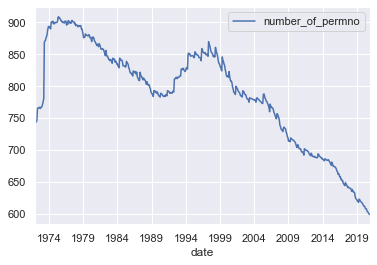

In [218]:
each_month_permno_num = pd.DataFrame(Counter(total_df.reset_index().date).items(), columns=['date', 'number_of_permno'])
each_month_permno_num.plot(x='date', y='number_of_permno')

## total:1972-2020 49 years
## training_length: 32 years; //28
## valid_length: 7 years ; //6
## testing_length: 7 years //6

In [219]:
X_total = total_df[features_list]
y_total = total_df['ret']

In [220]:
def train_val_test_preprocess(X_total, y_total, training_len, val_len, testing_len):
    """split our data into training set, validation set, and testing set

    Args:
        X_total (dataframe)
        y_total (dataframe)
        training_len (int): length of years of training set
        val_len (int)
        testing_len (int)
    return: dicts:X_train, y_train, X_val, y_val, X_test, y_test
    """
    X_train_dict = {}
    y_train_dict = {}
    X_val_dict = {}
    y_val_dict = {}
    X_test_dict = {}
    y_test_dict = {}
    first_train_end_year = y_total.index.year[0] + training_len - 1
    total_len = y_total.index.year[-1] - y_total.index.year[0] + 1
    last_train_end_year = first_train_end_year + total_len -(training_len+val_len+testing_len)
    train_end_years = np.arange(first_train_end_year, last_train_end_year+1)
    print('each end year of training set is:', train_end_years)
    for y in tqdm(train_end_years, desc='spliting data', ascii='>>'):
        train_start_year = y - training_len + 1
        train_end_year = y
        val_start_year = y + 1
        val_end_year = val_start_year+val_len-1
        test_start_year= val_end_year+val_len
        test_end_year = test_start_year+testing_len-1

        tmp_X_train = X_total[(X_total.index.year>=train_start_year) & (X_total.index.year<=train_end_year)]
        tmp_y_train = y_total[(y_total.index.year>=train_start_year) & (y_total.index.year<=train_end_year)]
        tmp_X_val = X_total[(X_total.index.year>=val_start_year) & (X_total.index.year<=val_end_year)]
        tmp_y_val = y_total[(y_total.index.year>=val_start_year) & (y_total.index.year<=val_end_year)]
        tmp_X_test = X_total[(X_total.index.year>=test_start_year) & (X_total.index.year<=test_end_year)]
        tmp_y_test = y_total[(y_total.index.year>=test_start_year) & (y_total.index.year<=test_end_year)]

        X_train_dict[y] = tmp_X_train
        y_train_dict[y] = tmp_y_train
        X_val_dict[y] = tmp_X_val
        y_val_dict[y] = tmp_y_val
        X_test_dict[y] = tmp_X_test
        y_test_dict[y] = tmp_y_test
    return train_end_years, X_train_dict, y_train_dict, X_val_dict, y_val_dict, X_test_dict, y_test_dict

In [221]:
train_end_years, X_train_dict, y_train_dict, X_val_dict, y_val_dict, X_test_dict, y_test_dict = train_val_test_preprocess(X_total, y_total, 32, 7, 7)

each end year of training set is: [2003 2004 2005 2006]


spliting data: 100%|>>>>>>>>>>| 4/4 [00:00<00:00,  5.49it/s]


In [222]:
# to save memory
del(X_total)
del(y_total)
del(total_df)
del(macro_df)
del(raw_df)
del(element)

In [223]:
from sklearn.linear_model import HuberRegressor

def out_of_sample_R_squared(pred, true):
    return 1 - (np.sum(np.square((pred-np.array(true)))) / np.sum(np.square(np.array(true))))

def rsquared_reduction_ols(X_train, y_train, specific_model):
    features = X_train.columns
    original_pred = (specific_model.predict(X_train))
    original_rsquared = out_of_sample_R_squared(original_pred, y_train)
    
    # 建立一个dataframe, 记录每一个变量变成0后的R-squared值
    rsquared_df = pd.DataFrame(columns=["R-squared", "R-squared Reduction"], index=features)
    
    # loop
    for feature in features:
        new_X_train = X_train.copy(deep=True)
        new_X_train[feature] = 0
        new_pred = (specific_model.predict(new_X_train))
        new_rsquared = out_of_sample_R_squared(new_pred, y_train)
        rsquared_df.loc[feature, "R-squared"] = new_rsquared
    
    rsquared_df["R-squared Reduction"] = np.abs(original_rsquared - np.array(rsquared_df["R-squared"]))
    rsquared_df["R-squared Normalized"] = rsquared_df["R-squared Reduction"] / rsquared_df["R-squared Reduction"].sum()
    rsquared_df = rsquared_df.sort_values(by="R-squared Normalized")
    
    return rsquared_df

def rsquared_reduction(X_train, y_train, specific_model):
    features = X_train.columns
    original_pred = (specific_model.predict(X_train)).flatten()
    original_rsquared = out_of_sample_R_squared(original_pred, y_train)
    
    # 建立一个dataframe, 记录每一个变量变成0后的R-squared值
    rsquared_df = pd.DataFrame(columns=["R-squared", "R-squared Reduction"], index=features)
    
    # loop
    for feature in features:
        new_X_train = X_train.copy(deep=True)
        new_X_train[feature] = 0
        new_pred = (specific_model.predict(new_X_train)).flatten()
        new_rsquared = out_of_sample_R_squared(new_pred, y_train)
        rsquared_df.loc[feature, "R-squared"] = new_rsquared
    
    rsquared_df["R-squared Reduction"] = np.abs(original_rsquared - np.array(rsquared_df["R-squared"]).flatten())
    rsquared_df["R-squared Normalized"] = rsquared_df["R-squared Reduction"] / rsquared_df["R-squared Reduction"].sum()
    rsquared_df = rsquared_df.sort_values(by="R-squared Normalized")
    
    return rsquared_df

def SSD(X_train, y_train, X_test, y_test, specific_model, epi=0.01):
    features = X_train.columns
    specific_model.fit(X_train, y_train)
    original_pred = (specific_model.predict(X_test)).flatten()
    
    # Document Derivatives
    ssd = pd.DataFrame(columns=["SSD"], index=features)
    
    # loop
    for feature in features:
        new_X_train = X_train.copy(deep=True)
        change = epi * np.array(new_X_train[feature])
        new_X_train[feature] = np.array(new_X_train[feature]) - change
        specific_model.fit(new_X_train, y_train)
        new_pred = (specific_model.predict(X_test)).flatten()
        ssd.loc[feature, "SSD"] = np.sum(np.square((new_pred - original_pred)/epi))
    
    return ssd

def OLS(X_train, y_train, X_test, y_test):
    Ols = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    ols_rd = rsquared_reduction_ols(sm.add_constant(X_train), y_train, Ols)
    plt.figure(figsize=(15, 15))
    plt.barh(ols_rd.index, ols_rd["R-squared Normalized"])
    plt.show()
    return out_of_sample_R_squared(Ols.predict(sm.add_constant(X_test)), y_test)

def OLS_Huber(X_train, y_train, X_test, y_test):
    # (1) epsilon(99.9% quantile) (2) alpha (3)
    r0 = 0
    epi = alp = 0
    for epi in np.arange(1, 1.5, 0.1):
        for alp in np.arange(0.01, 0.1, 0.01):
            huber = HuberRegressor(epsilon=epi, alpha=alp)
            huber.fit(X_train, y_train)
            tempr = out_of_sample_R_squared(huber.predict(X_train), y_train)
            if tempr > r0:
                epi = epi
                alp = alp
    huber = HuberRegressor(epsilon=epi, alpha=alp)
    huber.fit(X_train, y_train)
    ols_rd = rsquared_reduction(X_train, y_train, huber)
    plt.figure(figsize=(15, 15))
    plt.barh(ols_rd.index, ols_rd["R-squared Normalized"])
    plt.show()
    return out_of_sample_R_squared(huber.predict(X_test), y_test)

from sklearn.linear_model import ElasticNet

def ENet(X_train, y_train, X_test, y_test, alpha = 0.3):
    
    Enet = ElasticNet(alpha=alpha, l1_ratio=0.01)
    Enet.fit(X_train, y_train)    
    enet_rd = rsquared_reduction(X_train, y_train, Enet)
    plt.figure(figsize=(15, 15))
    plt.barh(enet_rd.index, enet_rd["R-squared Normalized"])
    plt.show()
    return out_of_sample_R_squared(Enet.predict(X_test), y_test)

def Lasso(X_train, y_train, X_test, y_test):
    return ENet(X_train, y_train, X_test, y_test, alpha = 1.0)

def Ridge(X_train, y_train, X_test, y_test):
    return ENet(X_train, y_train, X_test, y_test, alpha = 0.0)

def GLM(X_train, y_train, X_test, y_test):
    Glm = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gaussian()).fit(method="lbfgs")
    glm_rd = rsquared_reduction_ols(sm.add_constant(X_train), y_train, Glm)
    plt.figure(figsize=(15, 15))
    plt.barh(glm_rd.index, glm_rd["R-squared Normalized"])
    plt.show()
    return out_of_sample_R_squared(Glm.predict(sm.add_constant(X_test)), y_test)

from sklearn.cross_decomposition import PLSRegression

def PLS(X_train, y_train, X_test, y_test):
    pls = PLSRegression(n_components=11).fit(X_train, y_train)
    pls_rd = rsquared_reduction(X_train, y_train, pls)
    plt.figure(figsize=(15, 15))
    plt.barh(pls_rd.index, pls_rd["R-squared Normalized"])
    plt.show()
    return out_of_sample_R_squared(pls.predict(X_test), y_test)

from sklearn.preprocessing import scale 
from sklearn.decomposition import PCA

def PCR(X_train, y_train, X_test, y_test):
    X_train = pd.DataFrame(PCA().fit_transform(scale(X_train)), columns = X_train.columns, index = X_train.index)
    return OLS(X_train, y_train, X_test, y_test)


  0%|>>>>>>>>>>| 0/4 [00:00<?, ?it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


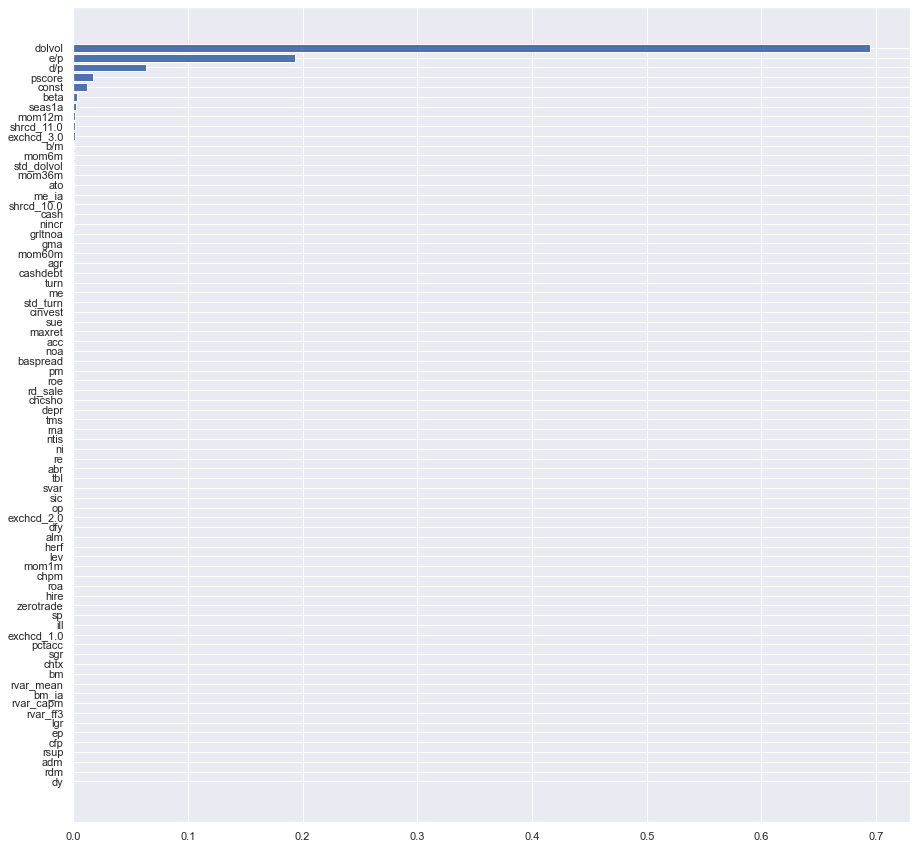

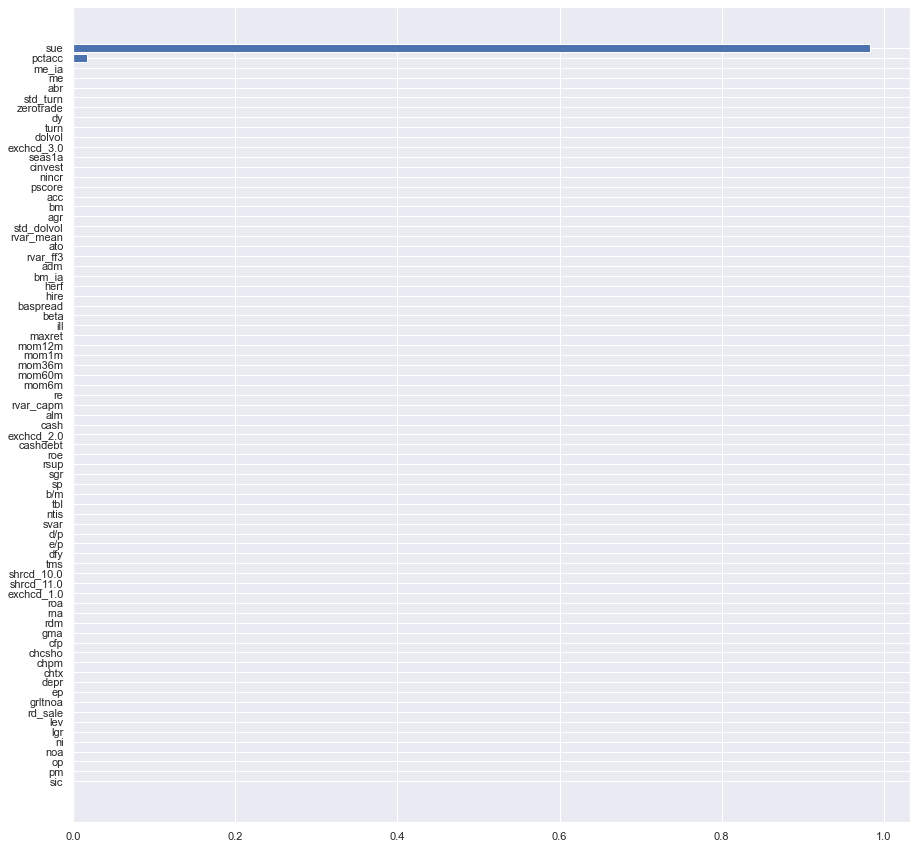

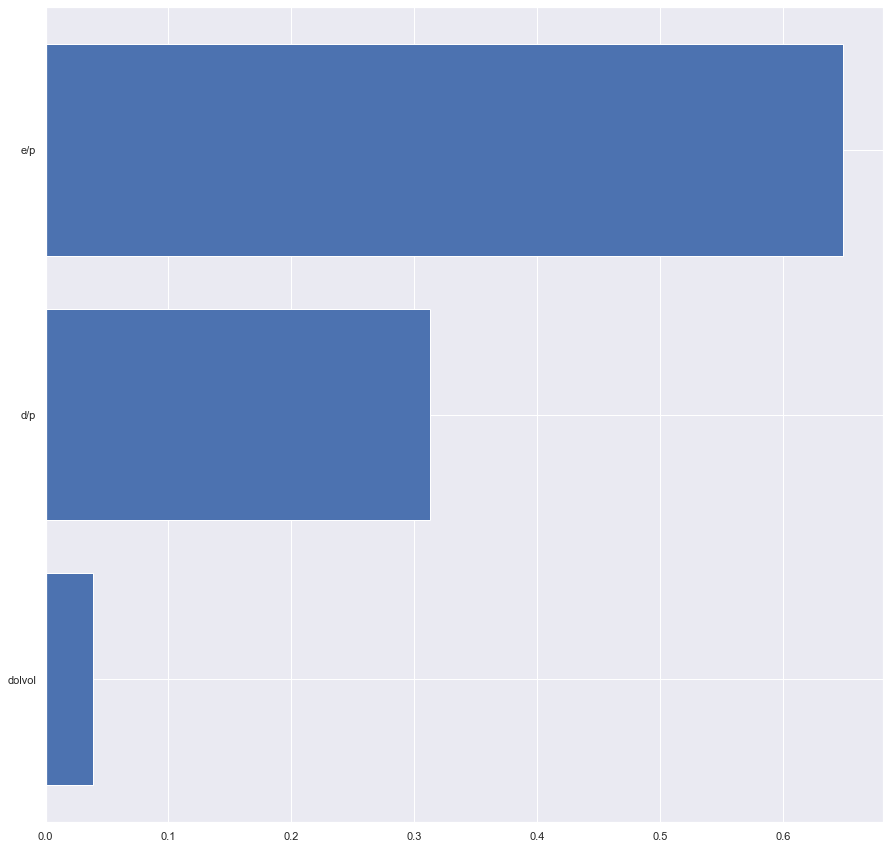

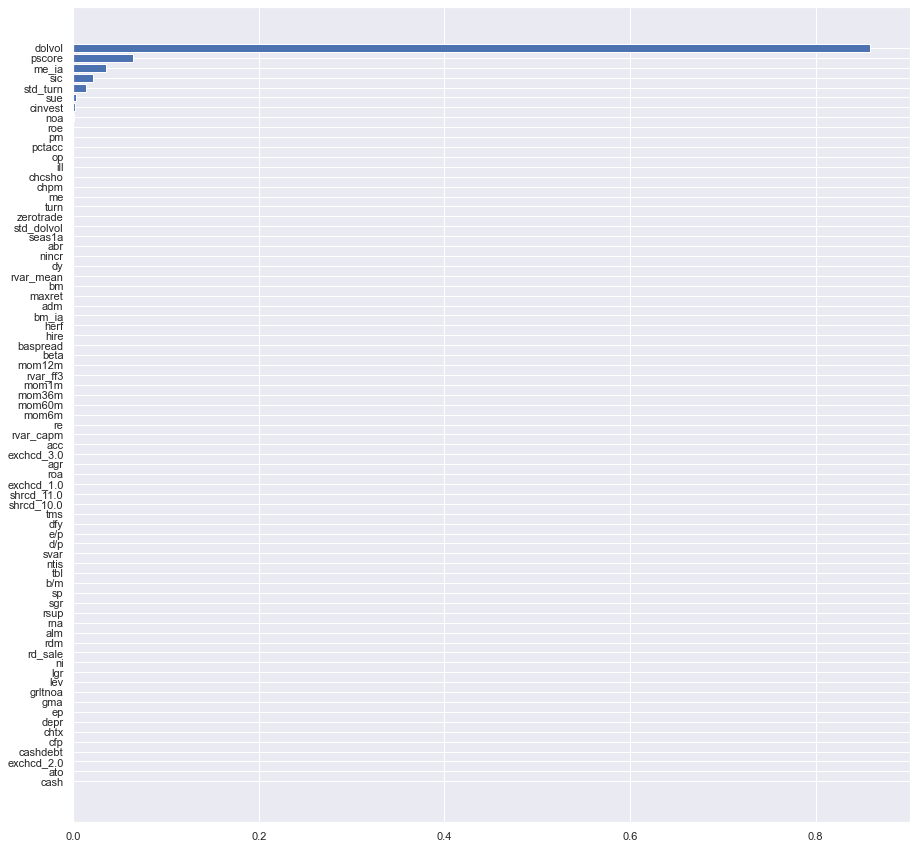

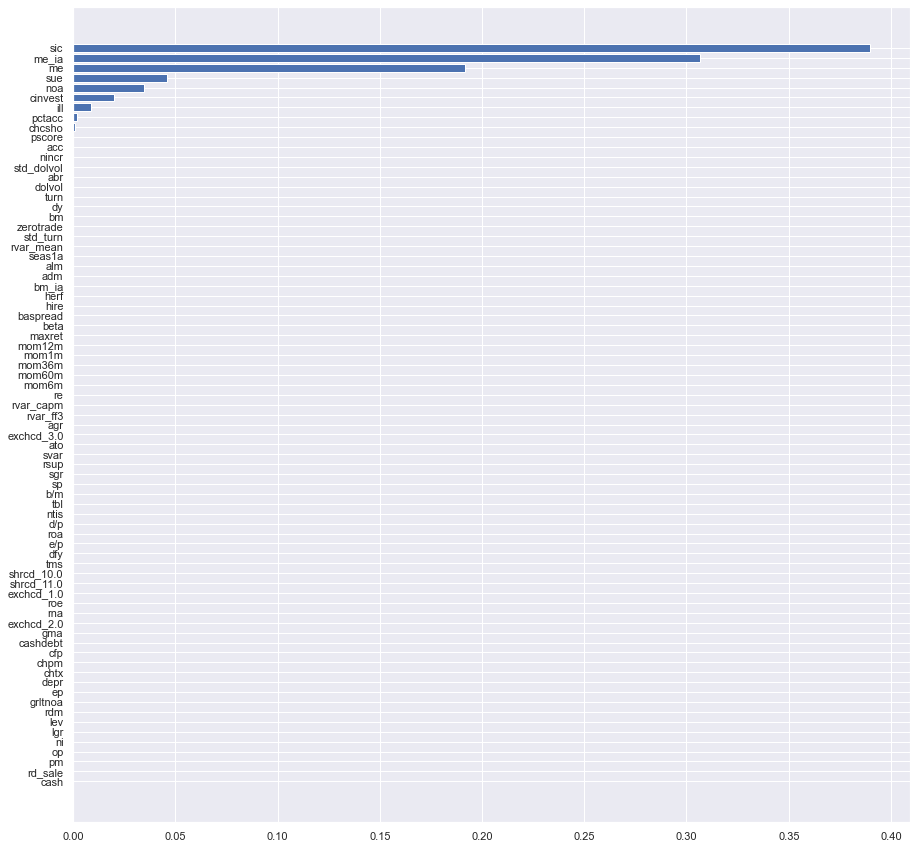

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
Coordinate descent with no regularization may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.435e+03, tolerance: 5.131e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


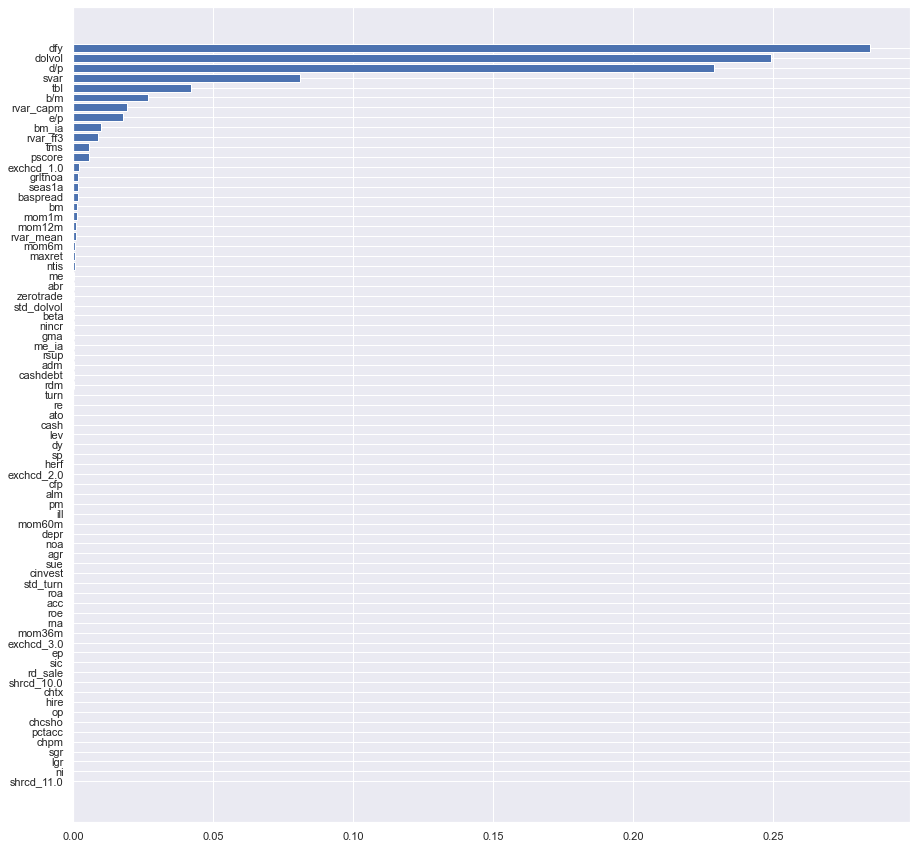

Inverting hessian failed, no bse or cov_params available


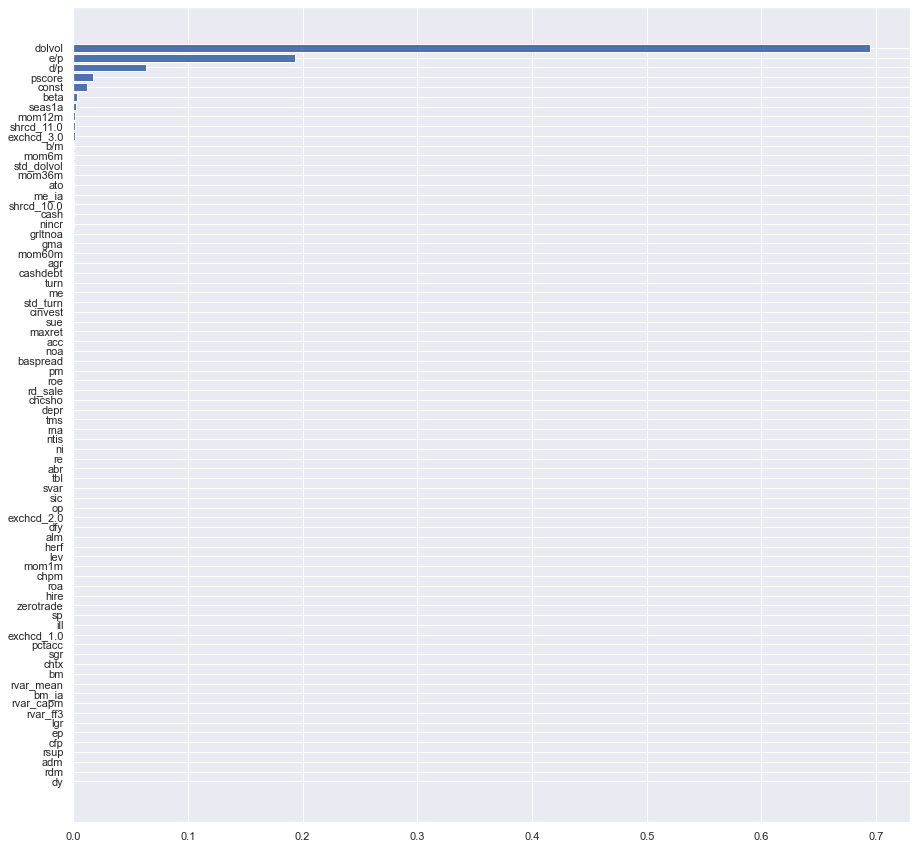

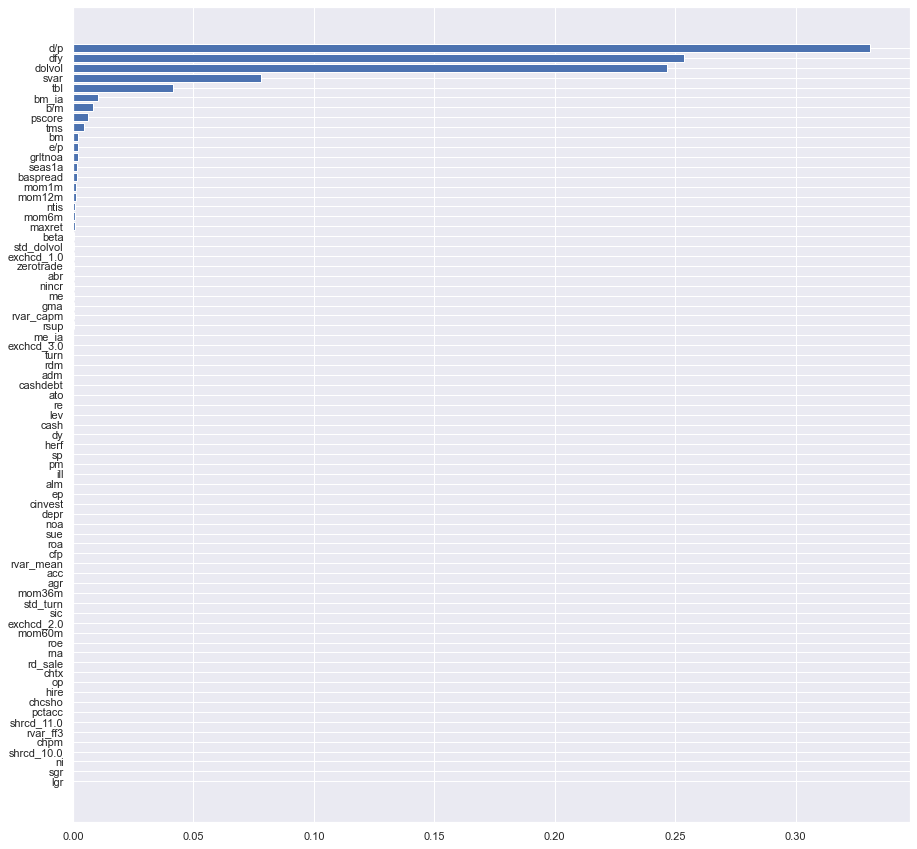

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


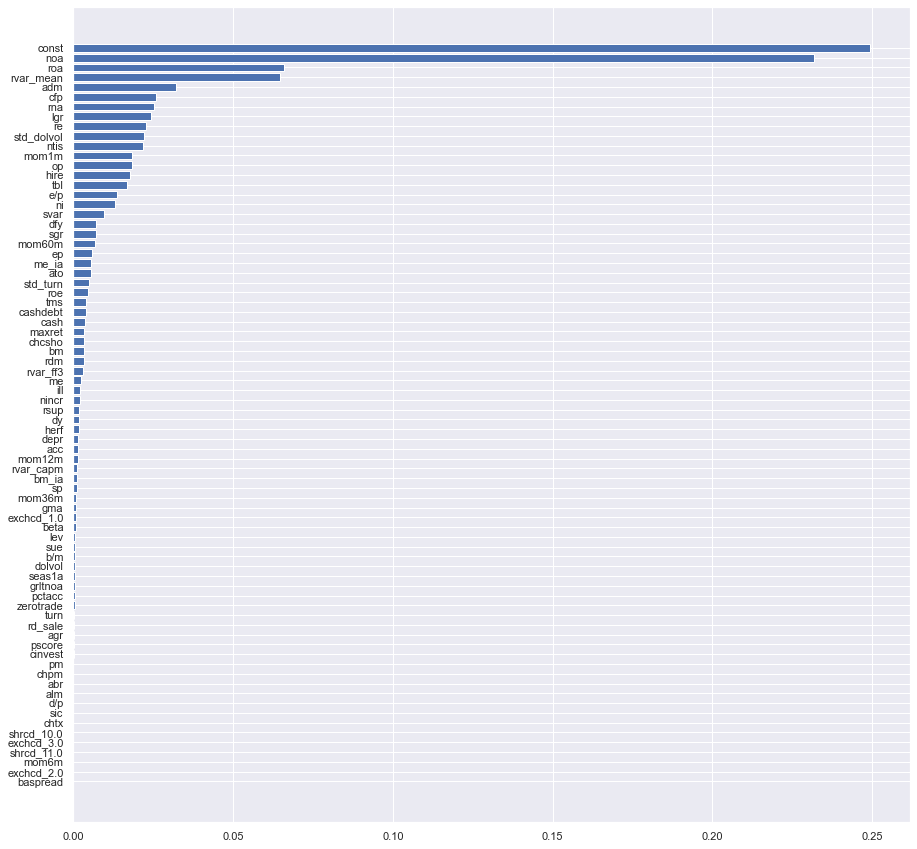

 25%|>>>>>>>>>>| 1/4 [12:19<36:59, 739.71s/it]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


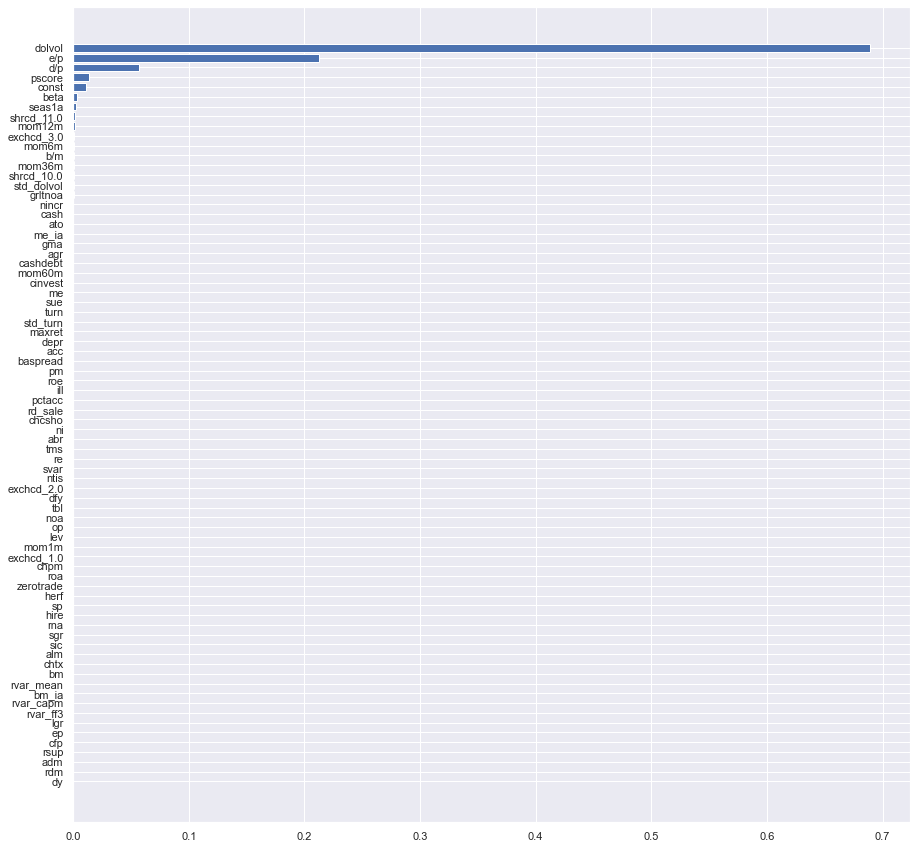

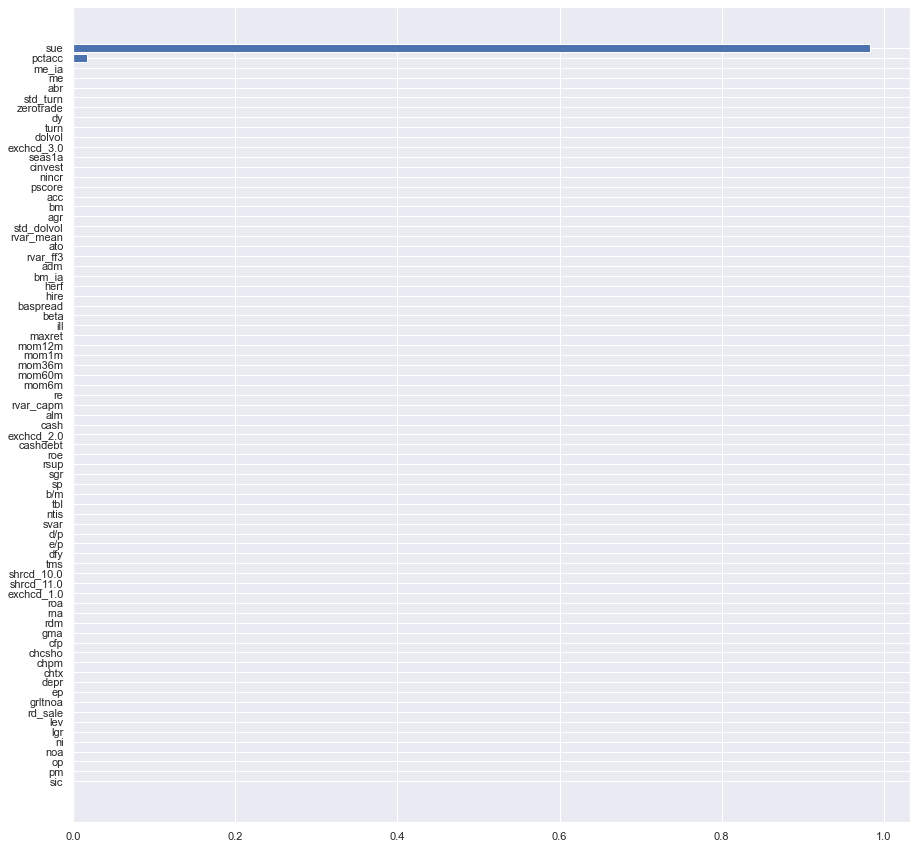

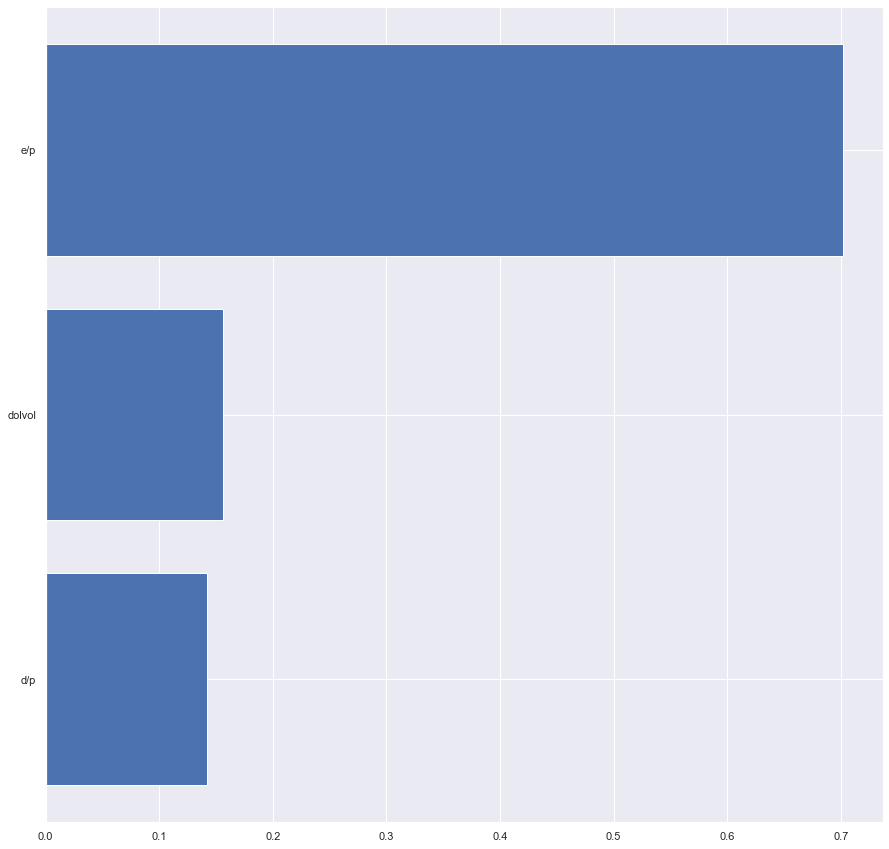

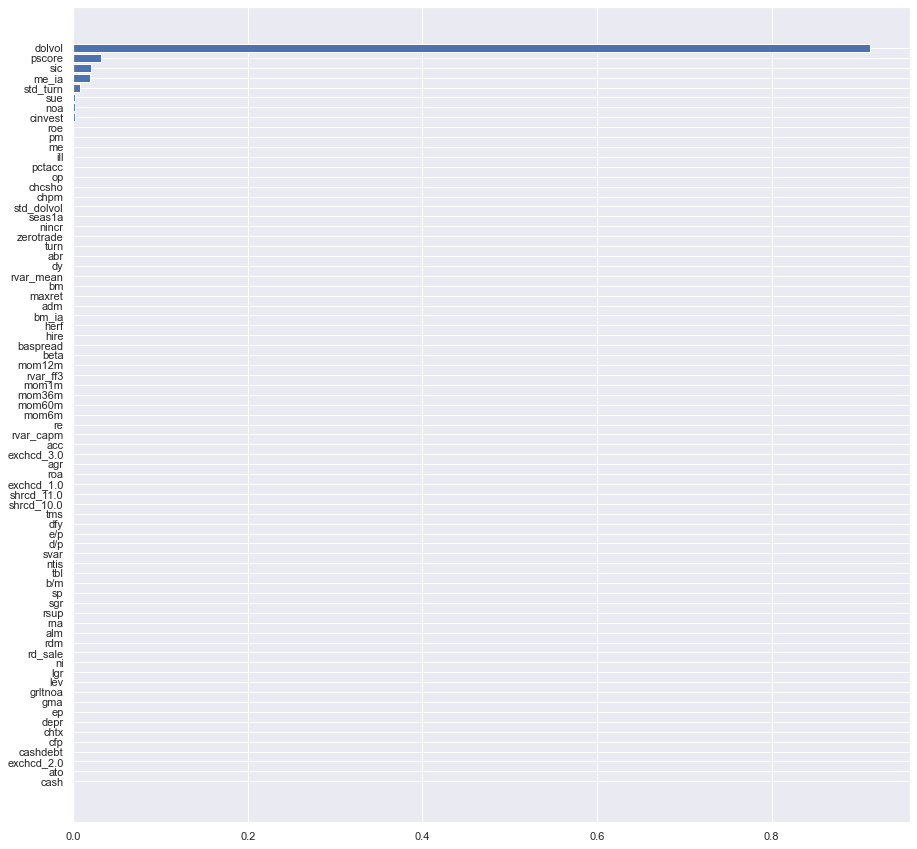

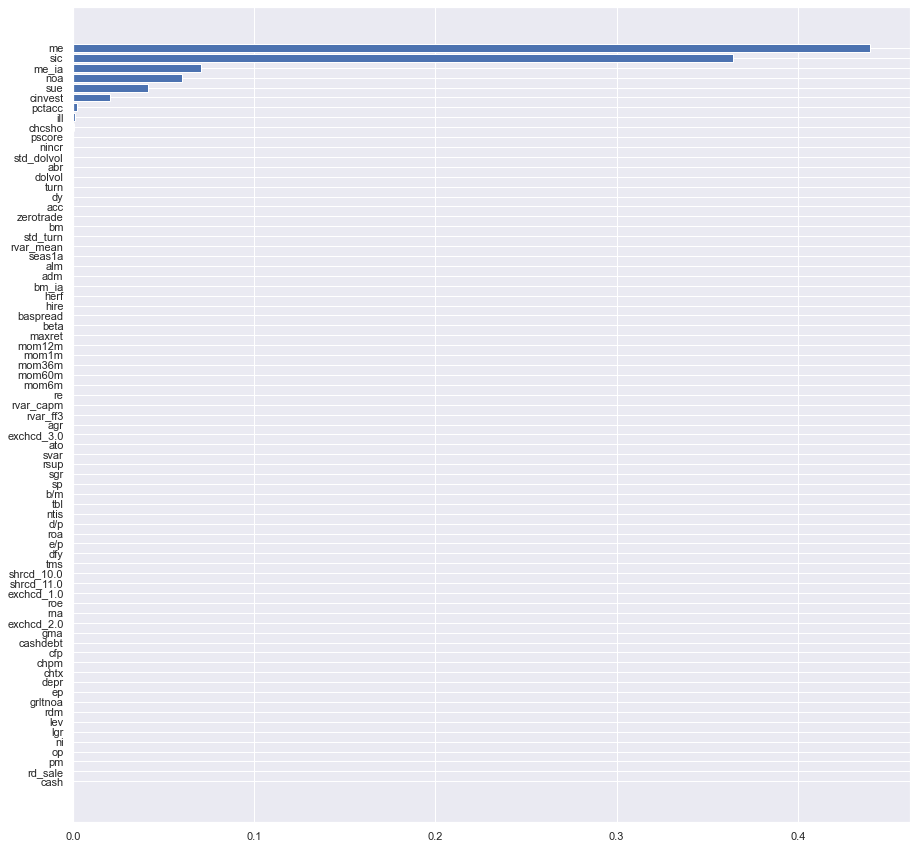

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
Coordinate descent with no regularization may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.442e+03, tolerance: 5.150e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


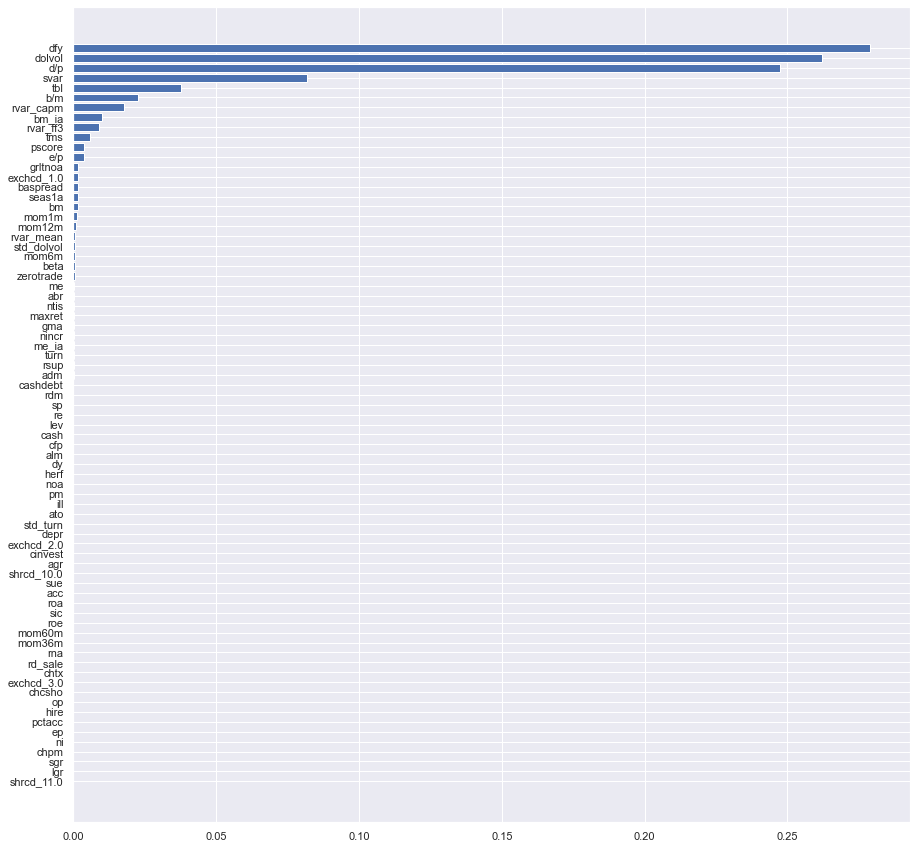

Inverting hessian failed, no bse or cov_params available


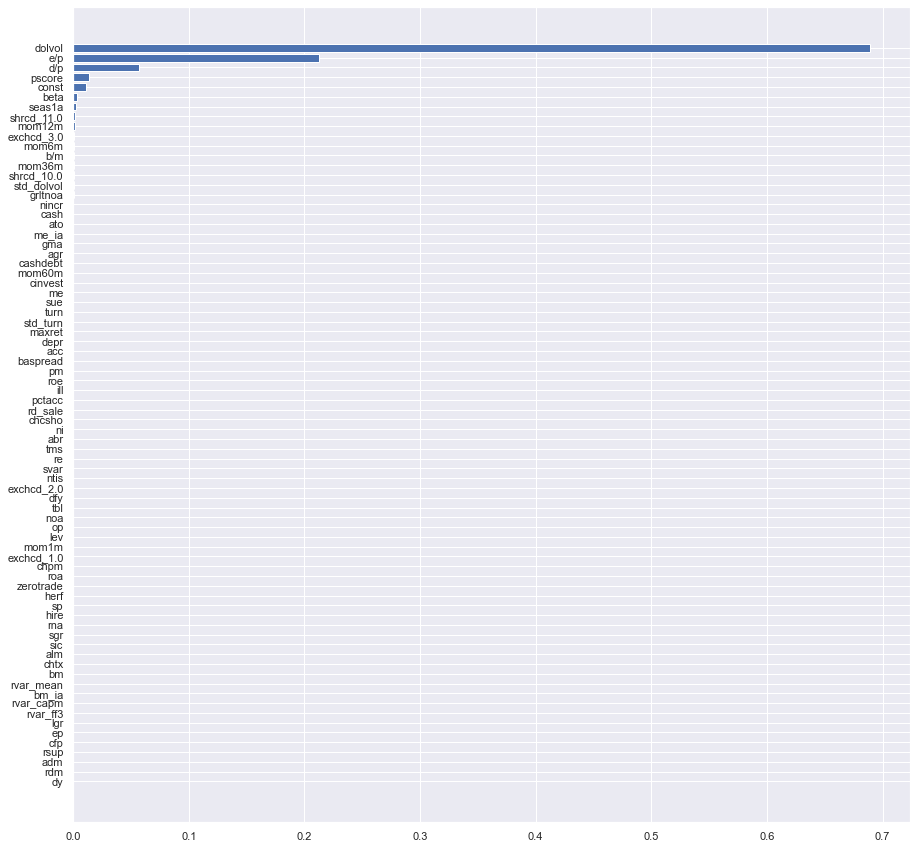

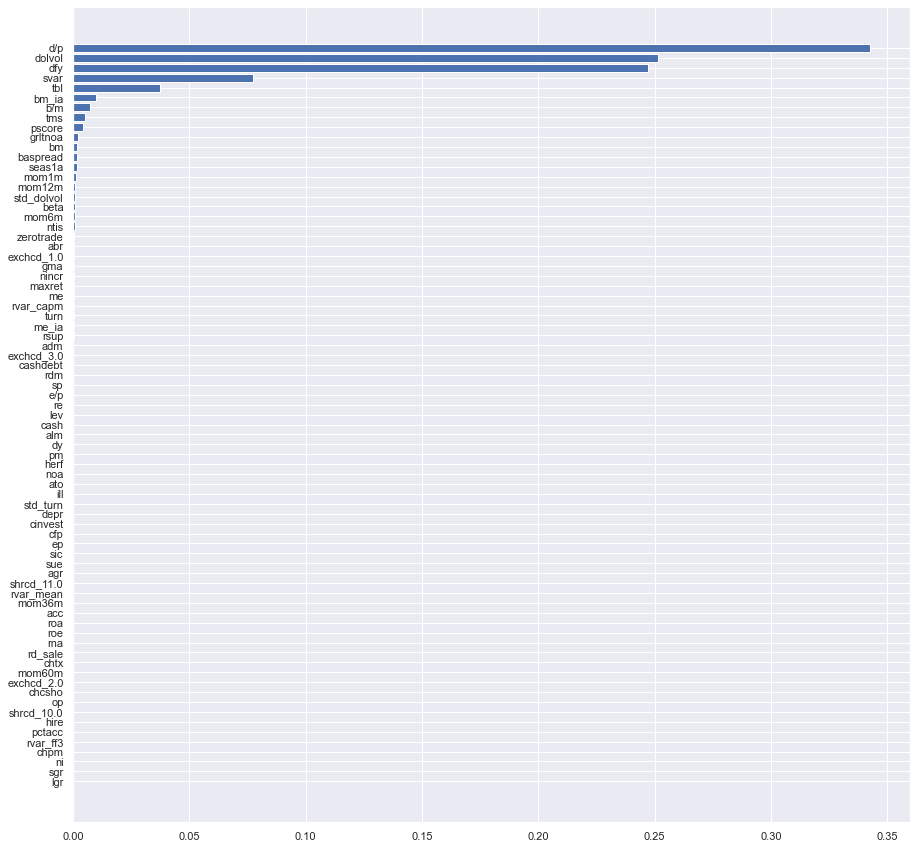

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


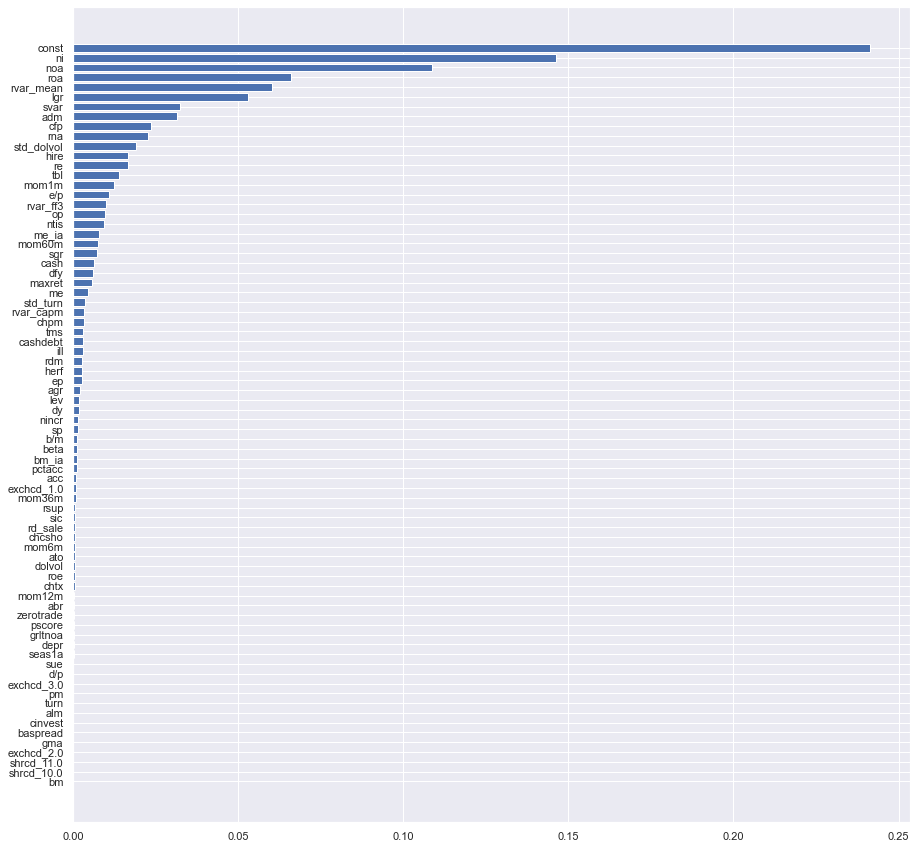

 50%|>>>>>>>>>>| 2/4 [25:14<25:20, 760.38s/it]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


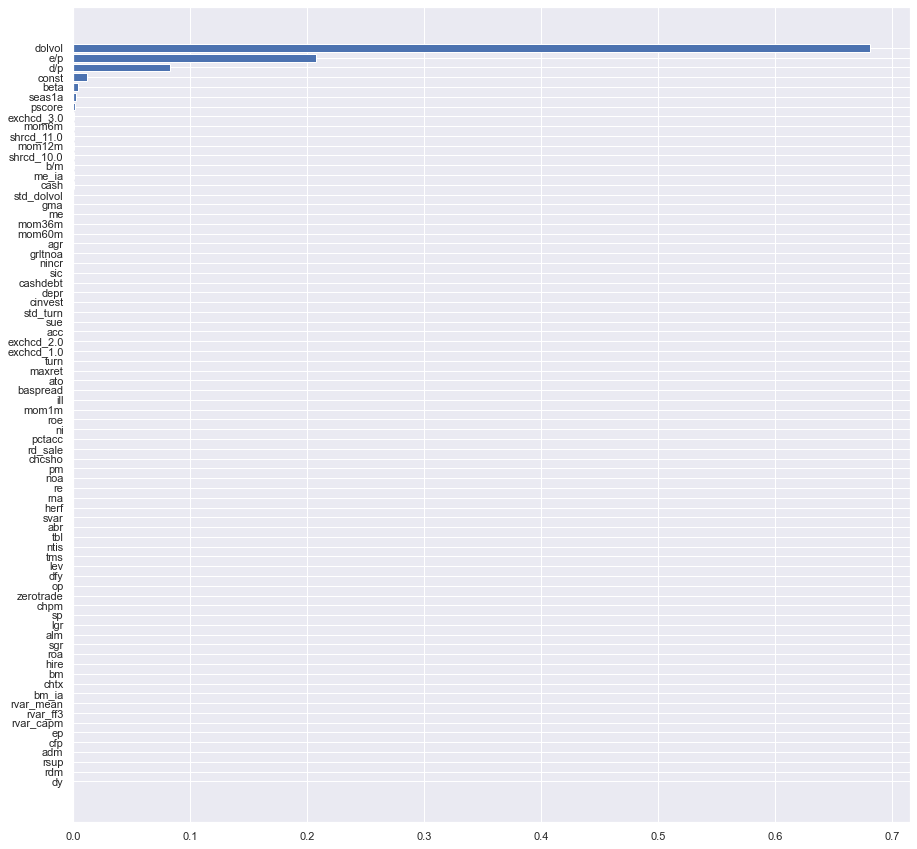

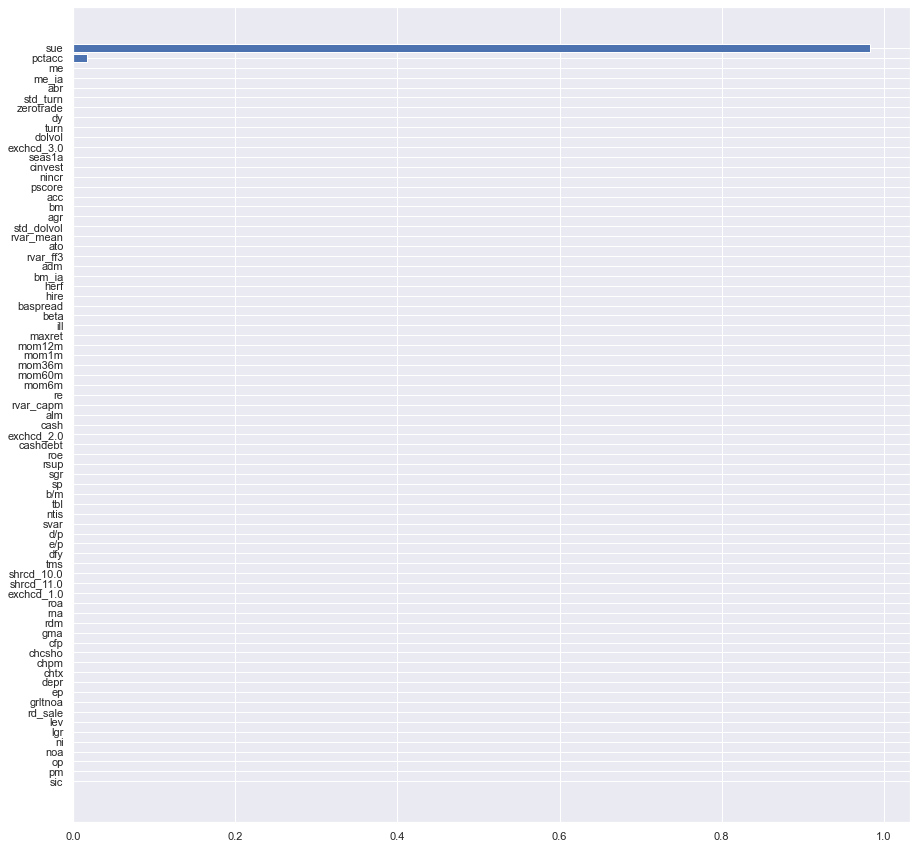

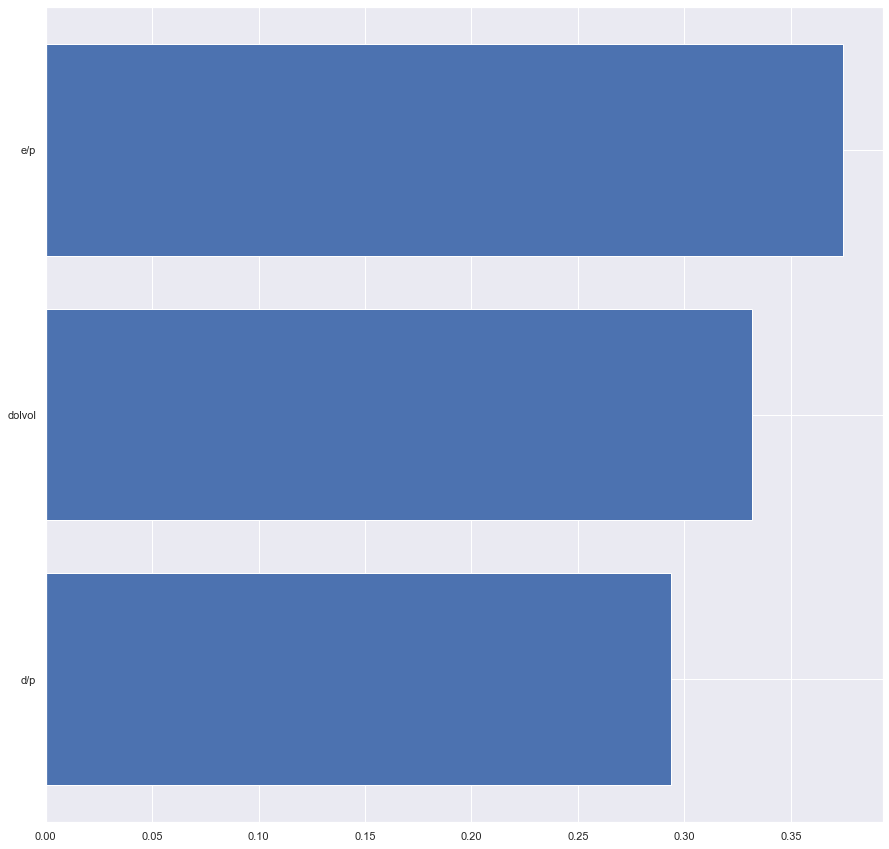

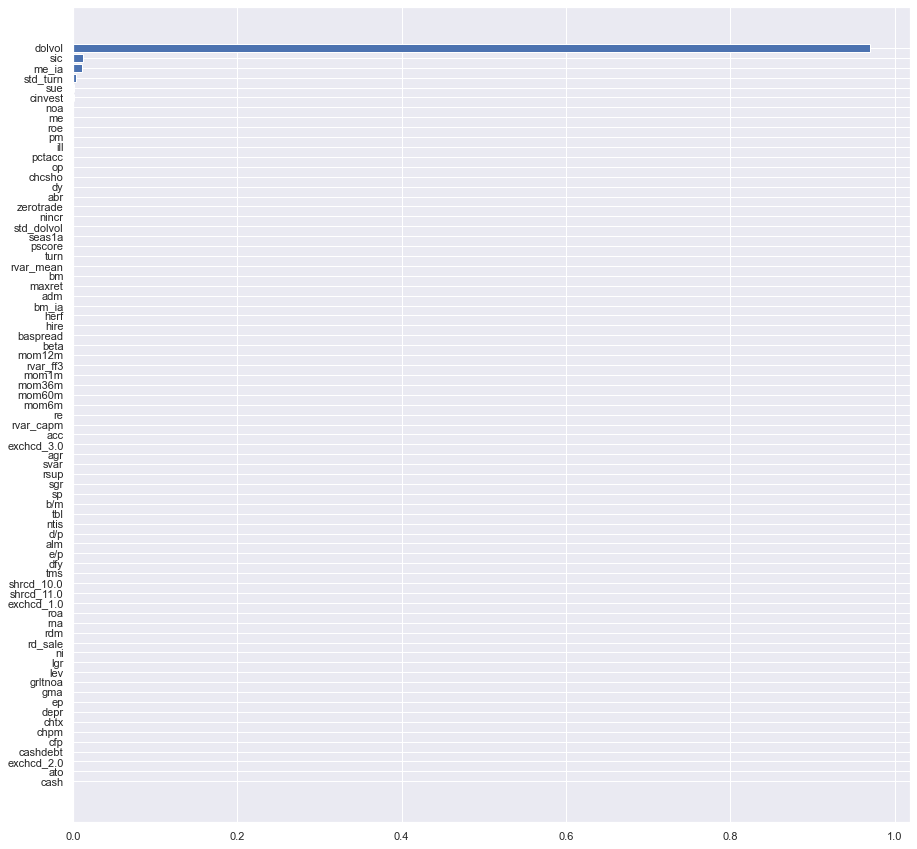

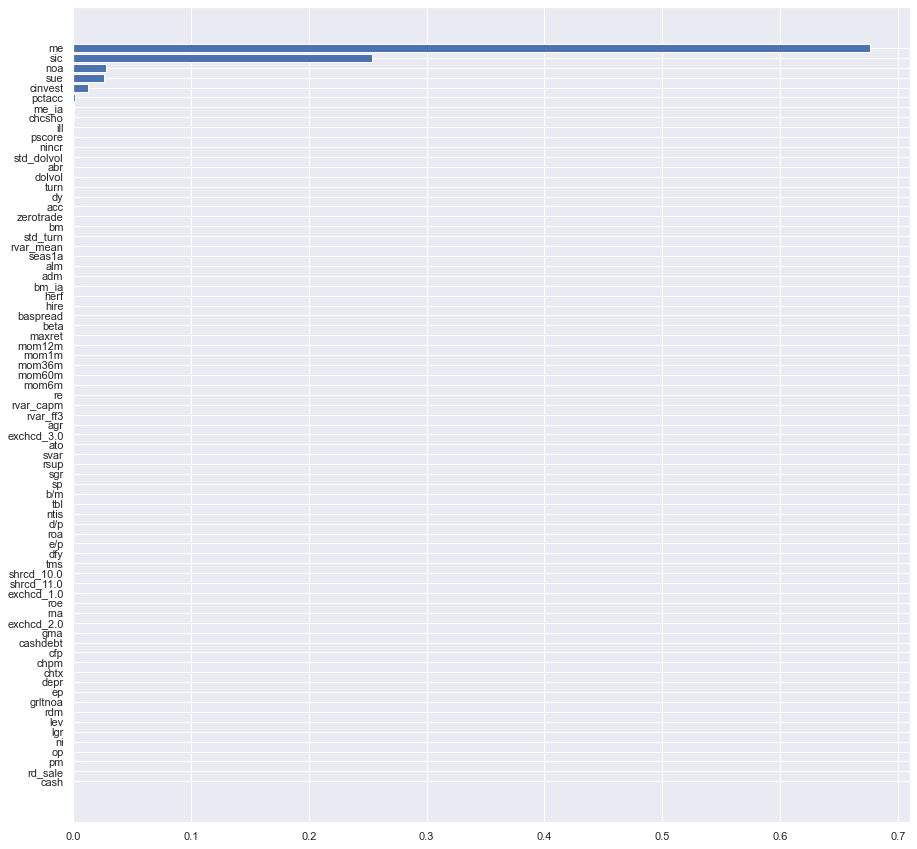

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
Coordinate descent with no regularization may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.399e+03, tolerance: 5.054e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


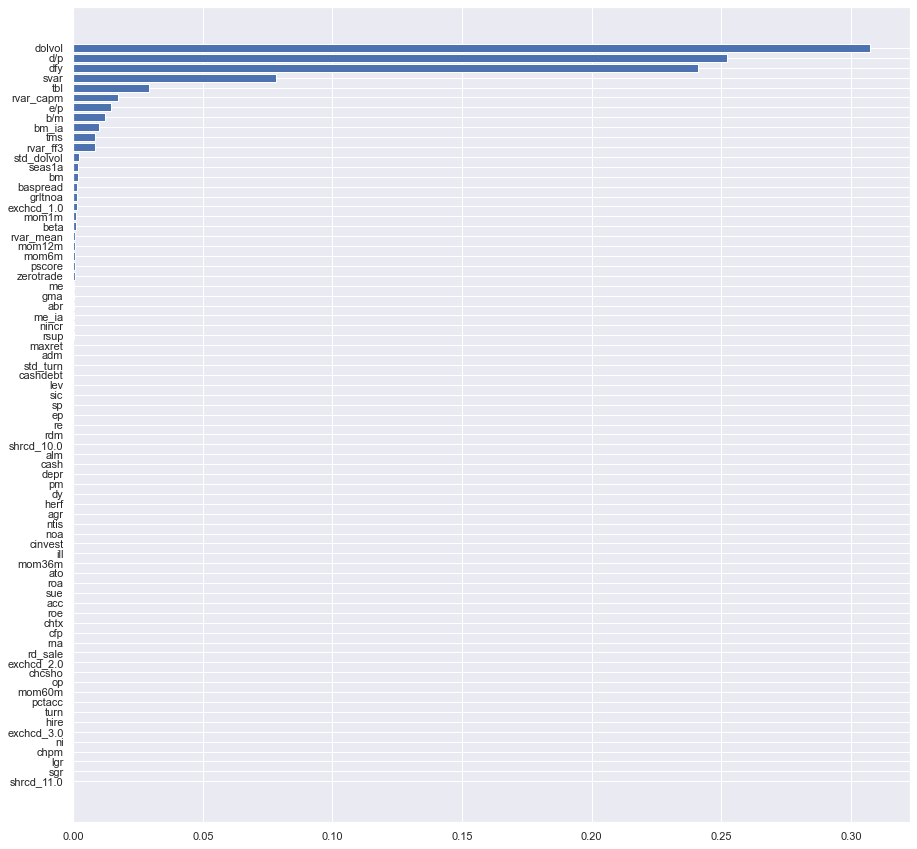

Inverting hessian failed, no bse or cov_params available


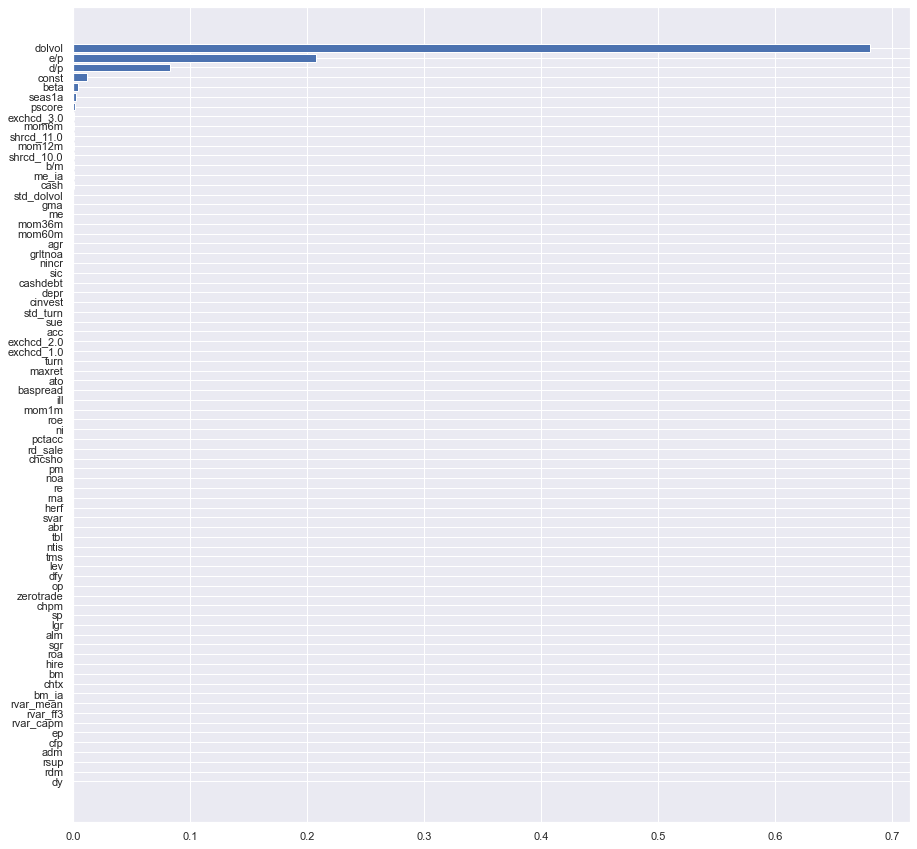

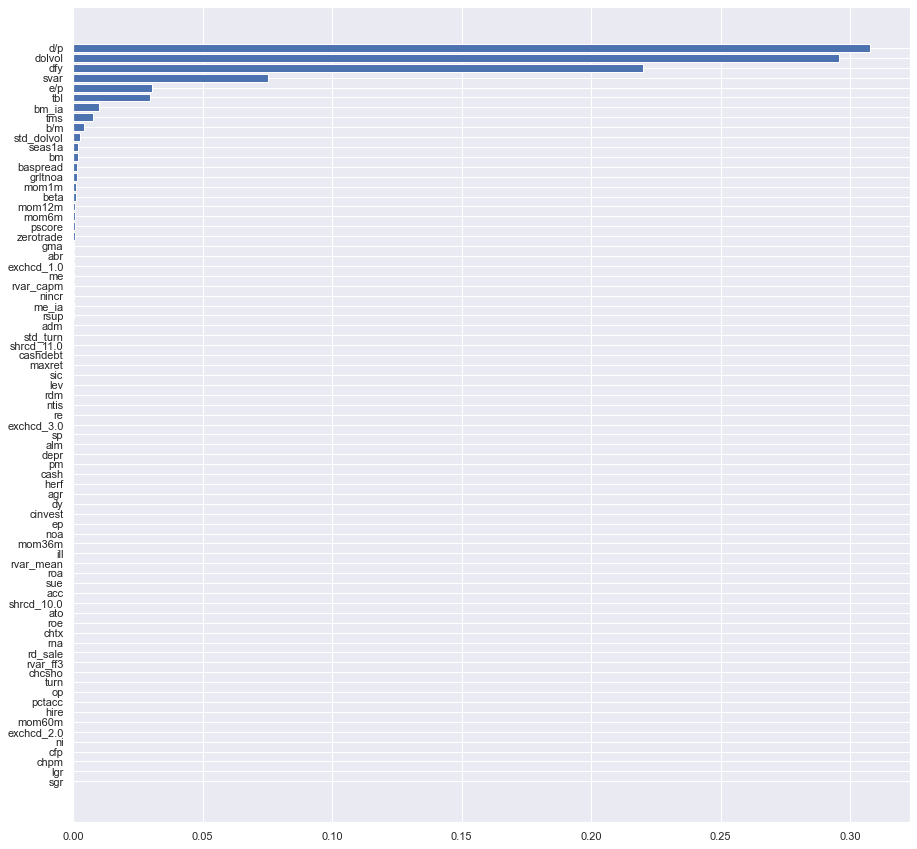

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


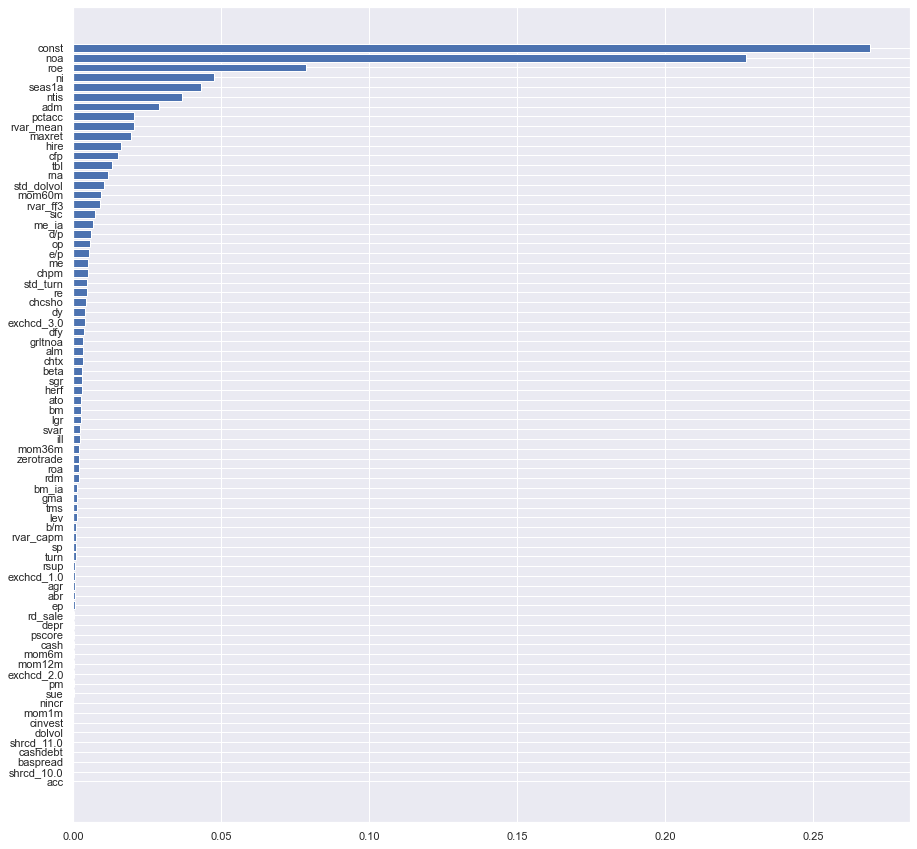

 75%|>>>>>>>>>>| 3/4 [37:38<12:32, 752.69s/it]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


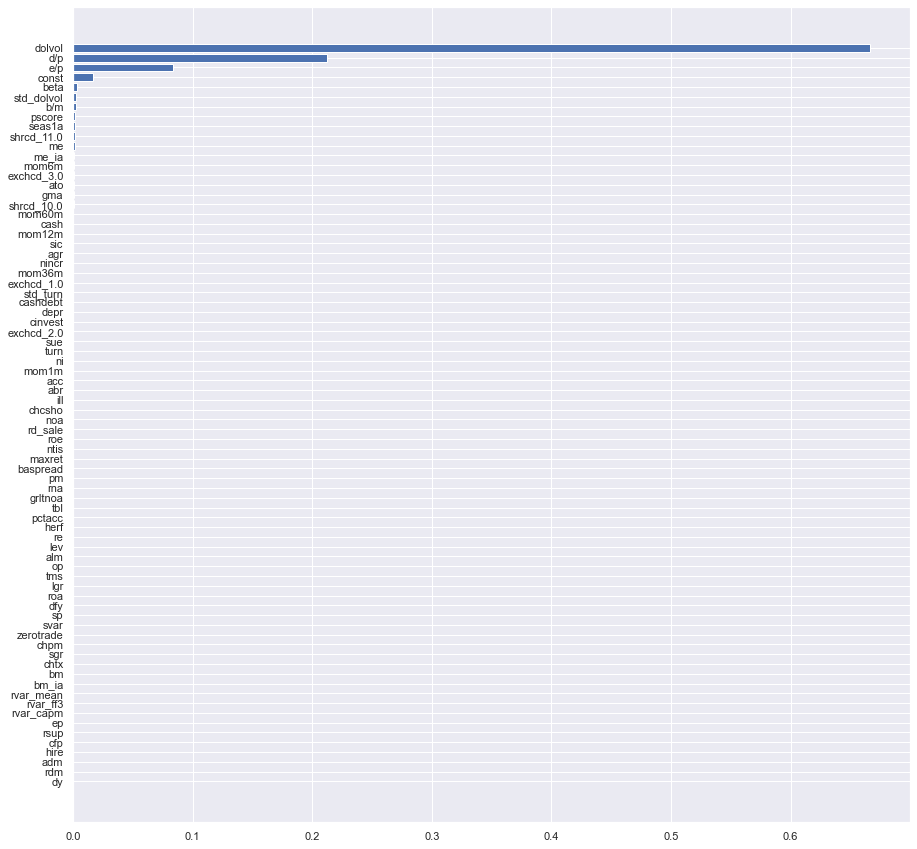

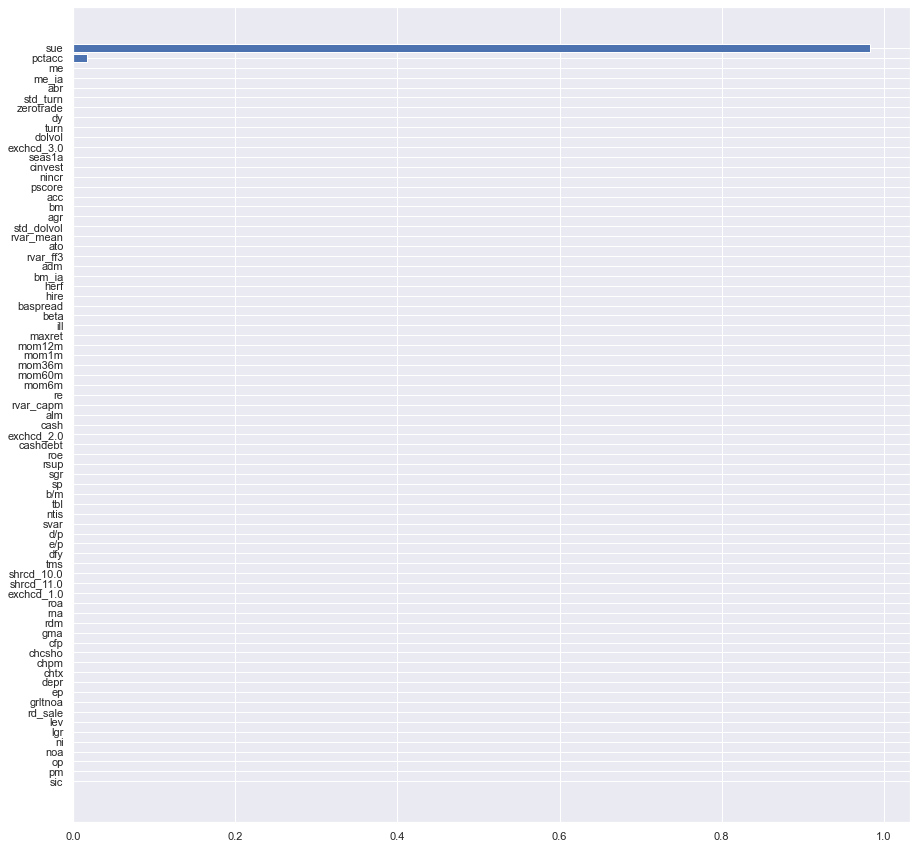

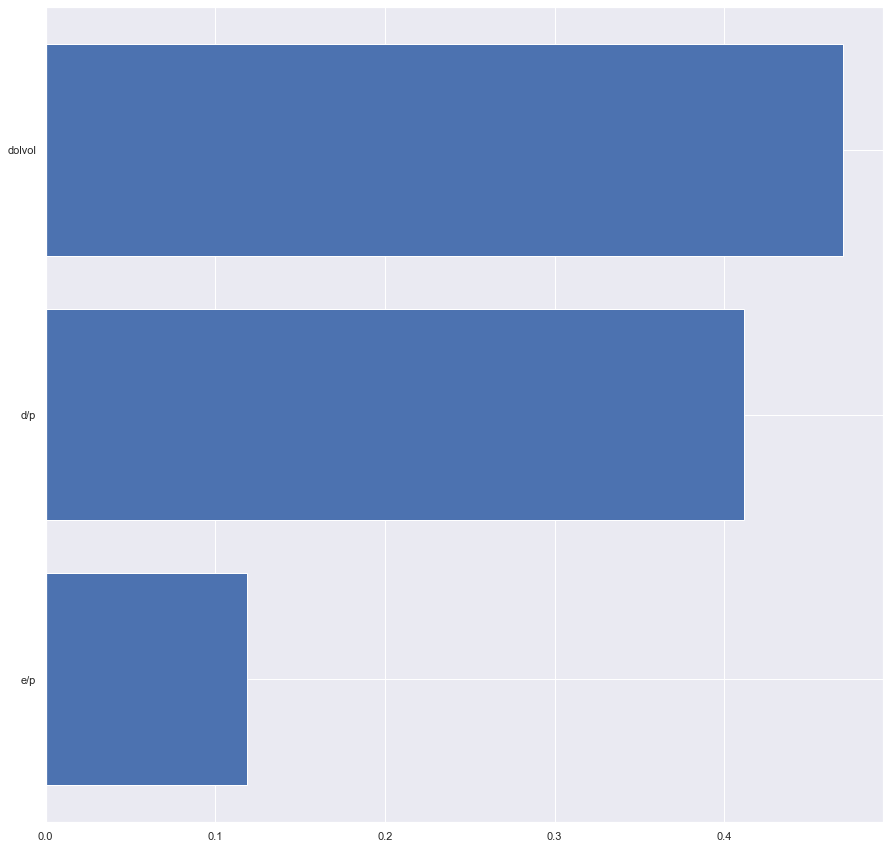

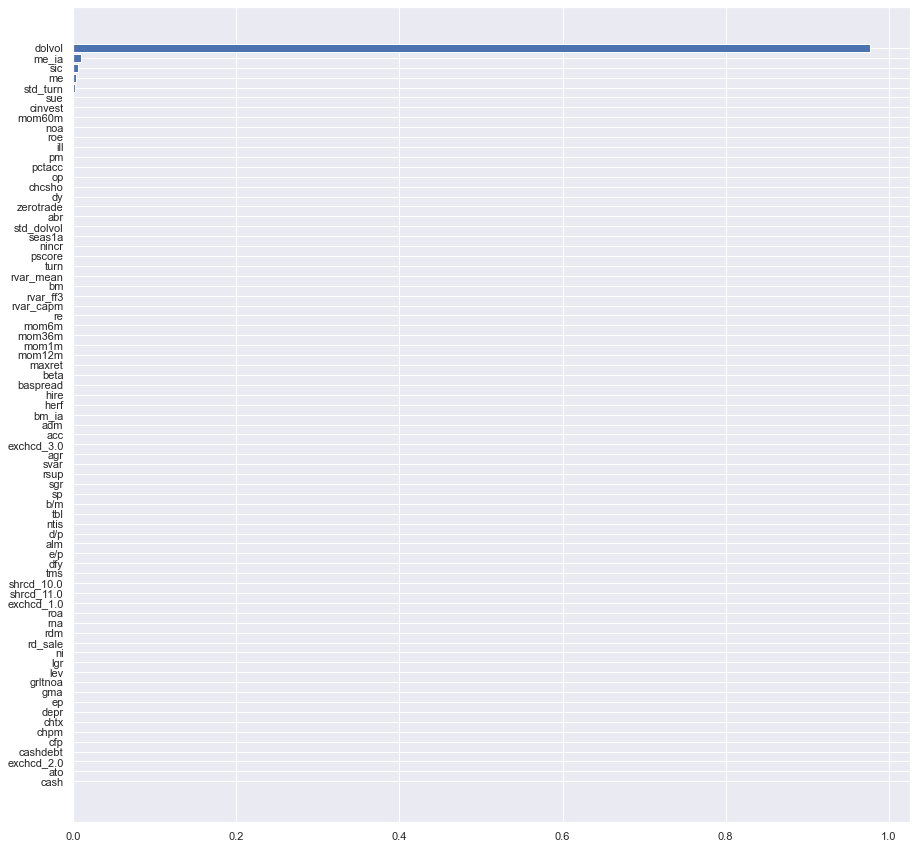

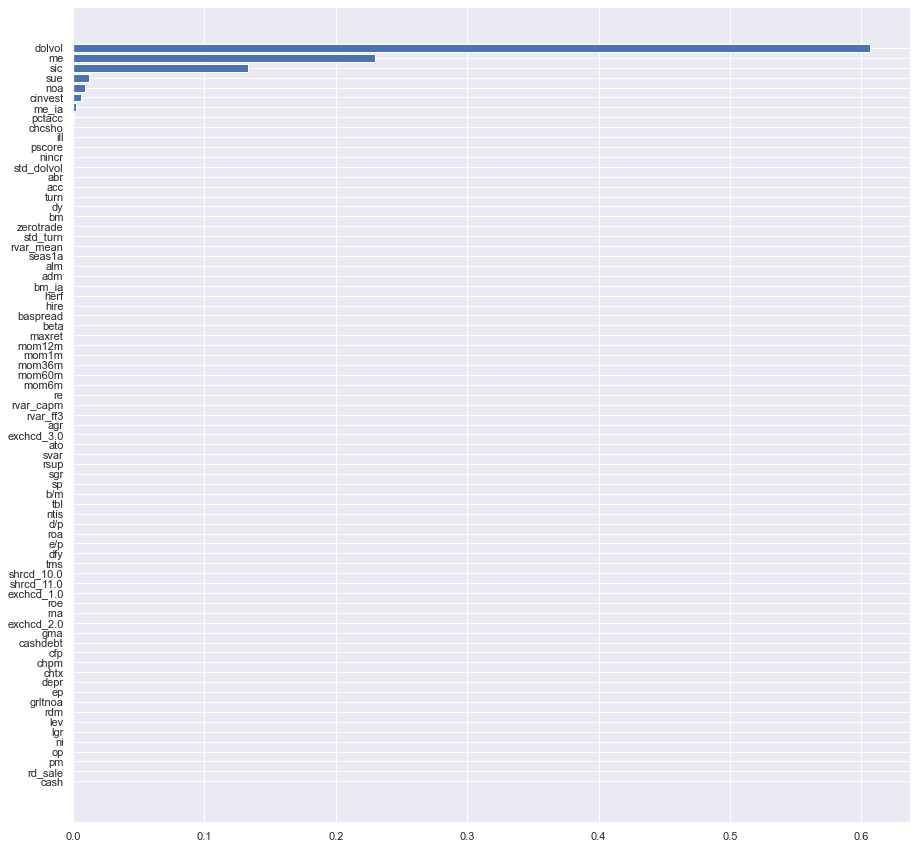

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
Coordinate descent with no regularization may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e+03, tolerance: 4.904e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


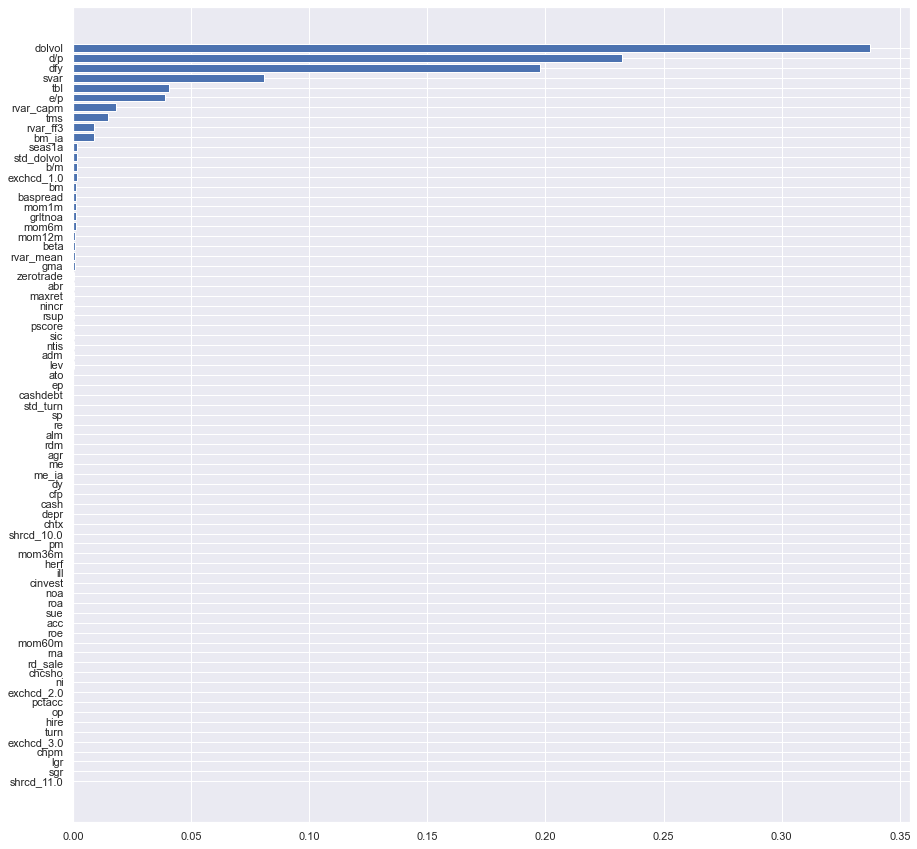

Inverting hessian failed, no bse or cov_params available


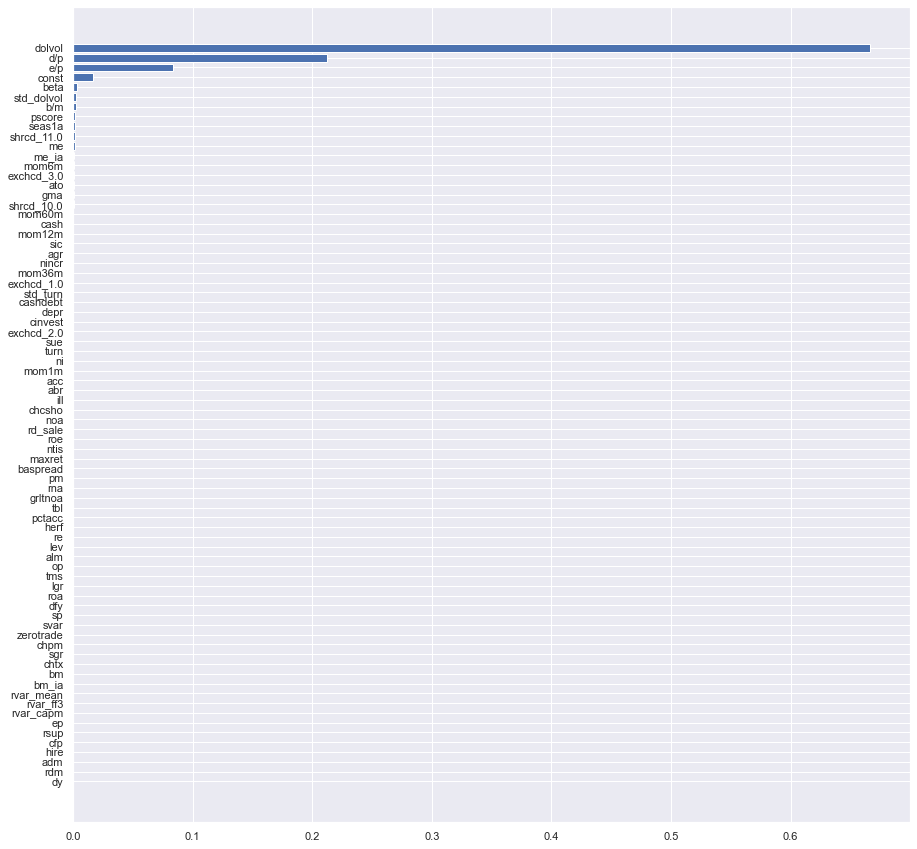

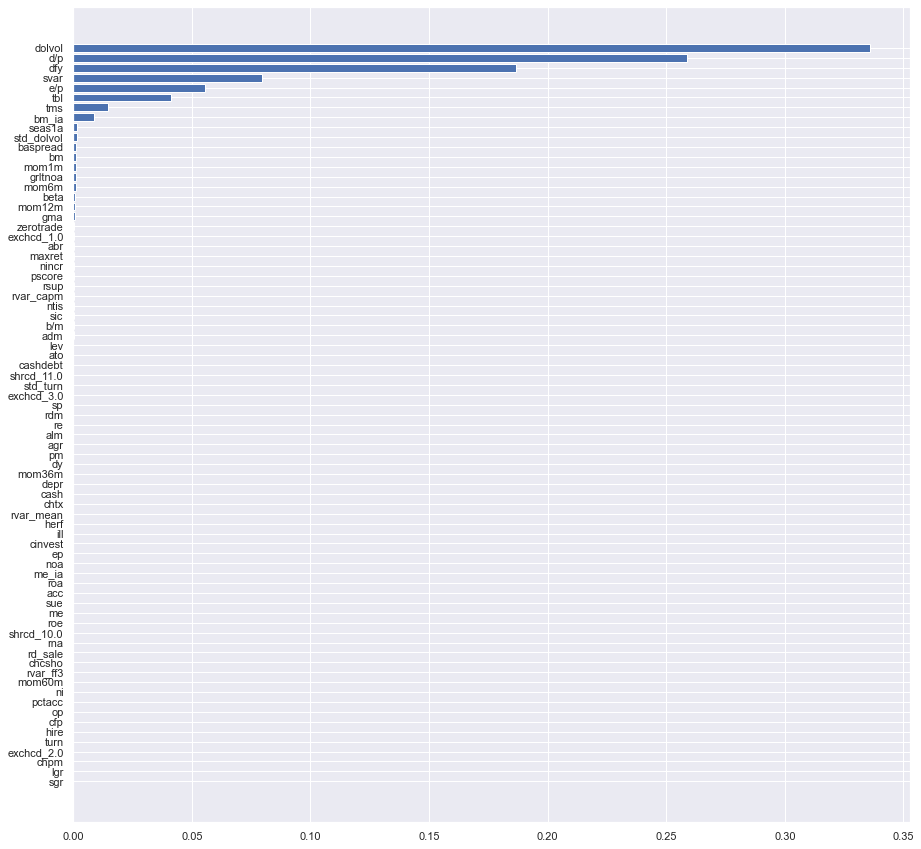

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


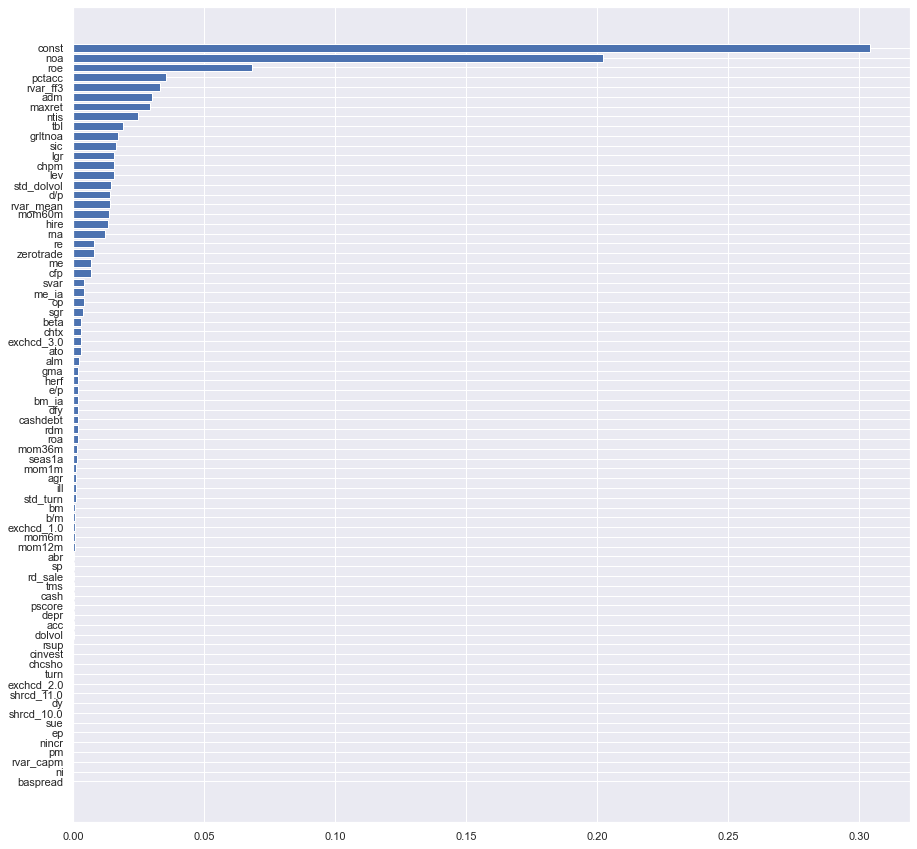

100%|>>>>>>>>>>| 4/4 [47:59<00:00, 719.88s/it]


In [225]:
if __name__ == '__main__':
    result = []
    for year in tqdm(train_end_years, ascii='>>'):
        X_train = X_train_dict[year].append(X_val_dict[year])
        y_train = y_train_dict[year].append(y_val_dict[year])
        X_test = X_test_dict[year]
        y_test = y_test_dict[year]
        ols_r_squared = OLS(X_train, y_train, X_test, y_test)
        Factor_3 = ['dolvol','d/p','e/p']
        ols_huber_r_squared = OLS_Huber(X_train, y_train, X_test, y_test)
        ols_huber_r_squared_3 = OLS_Huber(X_train[Factor_3], y_train, X_test[Factor_3], y_test)
        enet_r_squared = ENet(X_train, y_train, X_test, y_test)
        lasso_r_squared = Lasso(X_train, y_train, X_test, y_test)
        ridge_r_squared = Ridge(X_train, y_train, X_test, y_test)
        glm_r_squared = GLM(X_train, y_train, X_test, y_test)
        pls_r_squared = PLS(X_train, y_train, X_test, y_test)
        pcr_r_squared = PCR(X_train, y_train, X_test, y_test)
        result += [ols_r_squared, ols_huber_r_squared, ols_huber_r_squared_3, enet_r_squared, lasso_r_squared, ridge_r_squared, glm_r_squared, pls_r_squared, pcr_r_squared],

In [228]:
df = pd.DataFrame(result, columns = ['OLS', 'OLS Huber', 'OLS Huber 3 Factors', 'Elastic Net', 'Lasso', 'Ridge', 'Glm', 'PLS', 'PCR'], index = ['2003', '2004', '2005', '2006'])

In [230]:
df

,OLS,OLS Huber,OLS Huber 3 Factors,Elastic Net,Lasso,Ridge,Glm,PLS,PCR
2003,0.006102,3.297362e-14,0.015677,0.004969,0.002446,0.084816,0.006102,-35218.988233,-2.217815e+21
2004,0.006740,2.975398e-14,0.013413,0.003048,-0.000008,0.093406,0.006740,-26738.230596,-2.423109e+22
2005,0.019444,4.407585e-14,0.022428,0.015224,0.009050,0.119192,0.019444,-17927.854806,-1.945848e+23
2006,0.021986,3.952394e-14,0.016381,0.010983,0.004785,0.152936,0.021986,-9457.605717,-1.591905e+24


In [229]:
df.to_csv('R-squared.csv')